In [62]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import random
import re
import os
import glob
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import losses
from skimage.transform import resize
from keras import backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Resizing, Cropping2D, Input



In [63]:
#Limito la memoria de Tensorflow per poder utilitzar torch.
# gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
    
#     memory_limit = 14233  # mb
#     for gpu in gpus:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpu,
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])


In [64]:
#rutes
#image_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat'
#mask_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT'

#image_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat'
#mask_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT'

#image_dir='/kaggle/input/flood-area-segmentation/Image'
#mask_dir='/kaggle/input/flood-area-segmentation/Mask'
image_dir="/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/JPEGImages"
mask_dir="/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/SegmentationClassPNG"

In [65]:
#os.listdir(image_dir)

In [66]:
## Retallo les imatges per a que s'adequin al tamany necessari pel model.

image_list = []
resized_images = []

directory_path = image_dir
filenames=sorted(glob.glob(os.path.join(directory_path, '*.jpg')))

for filename in filenames:
    #print(filename)
    img = Image.open(filename)
    image_list.append(img)

for image in image_list:
    image = image.resize((590,444))
    resized_images.append(image)

#output_directory = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_images'
#output_directory ="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_images"
output_directory='/kaggle/working'
for (i, new) in enumerate(resized_images):
    new.save(os.path.join(output_directory, '{}{}.png'.format('resized_image', i+1)))


In [67]:
## Retallo les mascares per a que s'adequin al tamany necessari pel model.
masks_list = []
resized_masks = []

directory_path = mask_dir
filenames=sorted(glob.glob(os.path.join(directory_path, '*.png')))

for filename in filenames:
    #print(filename)
    msk = Image.open(filename)
    masks_list.append(msk)

for mask in masks_list:
    mask = mask.resize((590,444))
    resized_masks.append(mask)

#output_directory = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_masks'
#output_directory ="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_masks"
output_directory='/kaggle/working'

for (i, new) in enumerate(resized_masks):
    new.save(os.path.join(output_directory, '{}{}.png'.format('resized_mask', i+1)))



In [68]:
def load_images_and_masks(image_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            # Obtinc el numero d'imatge a partir del nom
            image_number = re.search(r'\d+', filename).group()

            # Carrego la imatge
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path))

            # Carrego la mascara corresponent
            mask_filename = f"resized_mask{image_number}.png"
            mask_path = os.path.join(image_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            
            #Normalitzo les mascares
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1) / 255.0

            # Guardo la imatge i la mascara en un diccionari
            images.append(image)
            masks.append(mask)
                
    return np.array(images),np.array(masks)



In [203]:
# mascares en blanc o negre:

def load_images_and_masks_bw(image_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            # Obtinc el numero d'imatge a partir del nom
            image_number = re.search(r'\d+', filename).group()

            # Carrego la imatge
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path))

            # Carrego la mascara corresponent
            mask_filename = f"resized_mask{image_number}.png"
            mask_path = os.path.join(image_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            
            # Binarizar la máscara (convertirla a solo blanco y negro)
            umbral = 20  # Umbral arbitrario (ajustalo según sea necesario)
            mask = np.where(mask > umbral, 255, 0)

            # Asegurar que la máscara tenga una dimensión de canal
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1)

            # Guardo la imatge y la mascara en un diccionari
            images.append(image)
            masks.append(mask)
                
    return np.array(images), np.array(masks)

In [158]:
def load_images_and_masks_bw(image_dir):
    images = []
    masks = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            # Obtinc el numero d'imatge a partir del nom
            image_number = re.search(r'\d+', filename).group()

            # Carrego la imatge
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path))

            # Aplica un umbral para convertir la imagen en blanco y negro
            _, image_bw = cv2.threshold(image, 0.1, 1, cv2.THRESH_BINARY)

            # Carrego la mascara corresponent
            mask_filename = f"resized_mask{image_number}.png"
            mask_path = os.path.join(image_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            
            # Aplica un umbral para convertir la máscara en blanco y negro
            _, mask_bw = cv2.threshold(mask, 0.1, 1, cv2.THRESH_BINARY)

            # Asegurar que la máscara tenga una dimensión de canal
            mask_bw = mask_bw.reshape(mask_bw.shape[0], mask_bw.shape[1], 1)

            # Guardo la imatge y la mascara en un diccionari
            images.append(image_bw)
            masks.append(mask_bw)
                
    return np.array(images), np.array(masks)

In [71]:
# # Pels altres datasets!!

# def load_images_and_masks(image_dir,mask_dir):
#     images = []
#     masks = []
#     for filename in os.listdir(image_dir):
#         if filename.endswith(".jpg"): #and "image" in filename:
#             # Obtinc el numero d'imatge a partir del nom
#             image_number = re.search(r'\d+', filename).group()

#             # Carrego la imatge
#             image_filename=f"um_{image_number}.jpg"
#             image_path = os.path.join(image_dir, filename)
#             image = np.array(Image.open(image_path))

#             # Carrego la mascara corresponent
#             mask_filename = f"{image_number}.png"
#             mask_path = os.path.join(mask_dir, mask_filename)
#             mask = np.array(Image.open(mask_path).convert('L'))
            
#             #Normalitzo les mascares
#             mask = mask.reshape(mask.shape[0], mask.shape[1], 1) / 255.0
            
#             print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")


#             # Guardo la imatge i la mascara en un diccionari
#             images.append(image)
#             masks.append(mask)
                
#     return np.array(images),np.array(masks)

In [204]:
# # Ruta de les imatges
# #image_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_images/'
# #image_dir = "/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_images"
image_dir='/kaggle/working'
#image_dir='/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/JPEGImages'
#mask_dir='/kaggle/input/semantic-segmentation-makassaridn-road-dataset/data_dataset_voc/SegmentationClassPNG'
# Carrego les imatges
images,masks = load_images_and_masks_bw(image_dir)


In [193]:
# def load_masks(mask_dir):
#      masks = []

#      for filename in os.listdir(mask_dir):
#          if filename.endswith(".png") and "mask" in filename:
             
#              mask_path = os.path.join(mask_dir, filename)
#              mask = np.array(Image.open(mask_path).convert("L"))
#              normalized_mask=mask/255.0
             
#              masks.append(normalized_mask)
#      return np.array(masks)



In [194]:
# # Ruta de les mascares
# #masks_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_masks'
# #masks_dir = "/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_masks"
#masks_dir="/kaggle/working"


# Carrego les imatges
#masks = load_masks(masks_dir)

In [205]:
# #Ajusto les imatges
# #adjusted_images = images.reshape(-1, 590, 444, 3)
masks = masks.reshape(-1, masks.shape[1], masks.shape[2], 1)

In [206]:
images.shape

(374, 444, 590, 3)

In [207]:
masks.shape

(374, 444, 590, 1)

In [208]:
images_reshaped = images.reshape((-1, 444, 590, 3))
masks_reshaped = masks.reshape((-1, 444, 590, 1))

In [209]:
X_train, X_test, y_train, y_test = train_test_split(images_reshaped,masks_reshaped, test_size=0.2, random_state=23)


In [269]:
def dice_coef(y_true, y_pred, smooth=1, th=0.1):
    y_true_f = tf.cast(K.flatten(y_true) > th,"float")
    y_pred_f = tf.cast(K.flatten(y_pred) > th, "float")
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [287]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [288]:
# Defineixo un Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [289]:
#Model
input_shape = (444,590, 3)
num_filters = 32


## Model més simple per mirar de solventar el problema de dimensions.
model = models.Sequential()
    
# Encoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

    
# Decoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef]) #dice coefficient

In [290]:
#### PROVA MODEL MÉS COMPLEX
input_shape = (444, 590, 3)
num_filters = 32

model2 = models.Sequential()

# Encoder
model2.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model2.add(BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2, 2)))

# Additional Encoder Layers
model2.add(layers.Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(layers.Activation('relu'))


# Decoder
model2.add(layers.Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(layers.Activation('relu'))


# Additional Decoder Layers
model2.add(layers.Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(layers.Activation('relu'))
model2.add(layers.UpSampling2D((2, 2)))

model2.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])


In [291]:
#Model 3
input_shape = (444, 590, 3)
num_filters = 64

model3 = models.Sequential()

# Encoder
model3.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D((2, 2)))

# Additional Encoder Layers
model3.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

# Decoder
model3.add(Conv2D(2*num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))


# Additional Decoder Layers
model3.add(Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(UpSampling2D((2, 2)))
model3.add(Conv2DTranspose(num_filters, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
#model.add(UpSampling2D((2, 2)))

# Output layer
model3.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
#lineal amb mse.




In [292]:
# Train the model
history=model.fit(X_train, y_train, epochs=50, batch_size=8,validation_data=(X_test,y_test),callbacks=[early_stopping])


Epoch 1/50
38/38 [==============================] - 6s 118ms/step - loss: -172.0403 - dice_coef: 1.4211 - val_loss: -38.1755 - val_dice_coef: 1.3529
Epoch 2/50
38/38 [==============================] - 4s 99ms/step - loss: -913.5421 - dice_coef: 1.7966 - val_loss: -93.8457 - val_dice_coef: 1.6041
Epoch 3/50
38/38 [==============================] - 4s 99ms/step - loss: -2005.2811 - dice_coef: 1.9023 - val_loss: -130.2580 - val_dice_coef: 1.4935
Epoch 4/50
38/38 [==============================] - 4s 100ms/step - loss: -3381.1709 - dice_coef: 1.9215 - val_loss: -3296.0435 - val_dice_coef: 1.9480
Epoch 5/50
38/38 [==============================] - 4s 100ms/step - loss: -4934.0532 - dice_coef: 1.9283 - val_loss: -403.4507 - val_dice_coef: 1.6099
Epoch 6/50
38/38 [==============================] - 4s 100ms/step - loss: -6583.8730 - dice_coef: 1.9433 - val_loss: -79.2720 - val_dice_coef: 1.5203
Epoch 7/50
38/38 [==============================] - 4s 100ms/step - loss: -8699.9316 - dice_coef: 1.

In [296]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_234 (Conv2D)         (None, 444, 590, 32)      896       
                                                                 
 batch_normalization_234 (B  (None, 444, 590, 32)      128       
 atchNormalization)                                              
                                                                 
 activation_234 (Activation  (None, 444, 590, 32)      0         
 )                                                               
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 222, 295, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_235 (Conv2D)         (None, 222, 295, 32)      9248      
                                                     

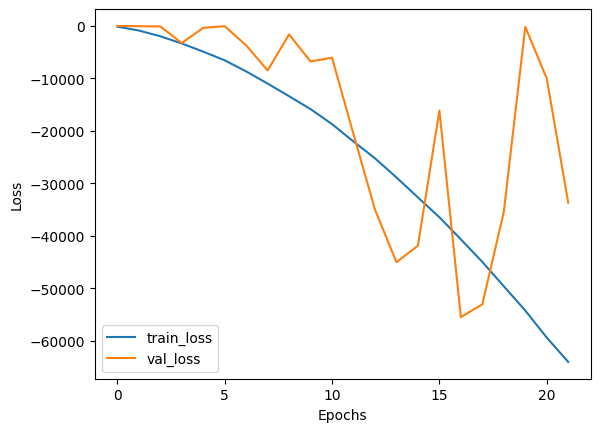

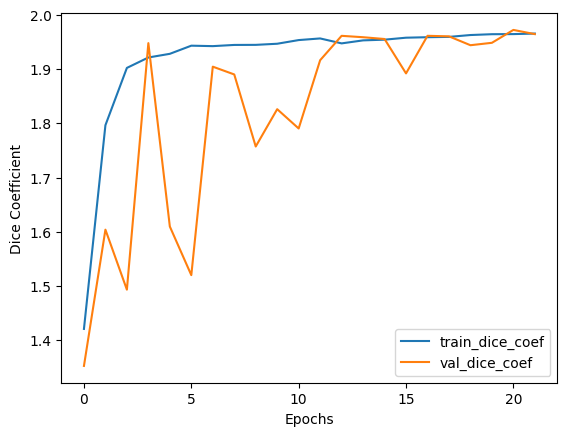

In [297]:
#Faig gràfics per veure com entrena el model
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['dice_coef'], label='train_dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

[173, 192, 106, 132, 289]
1/1 [==============================] - 0s 24ms/step


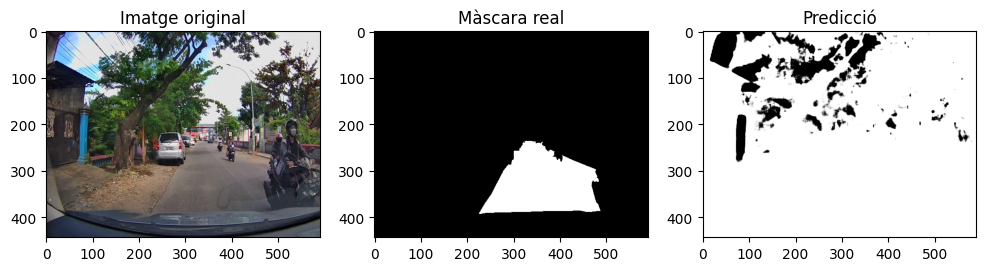

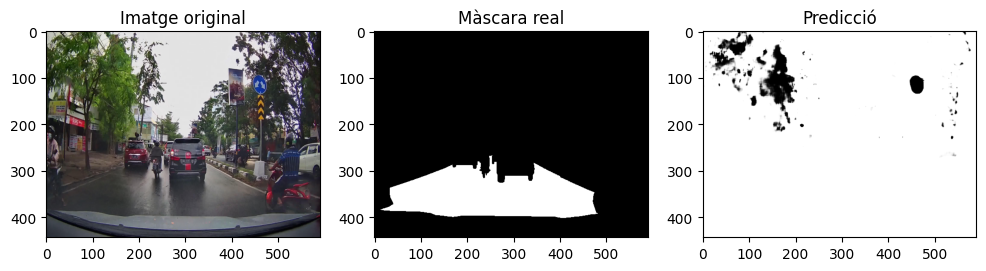

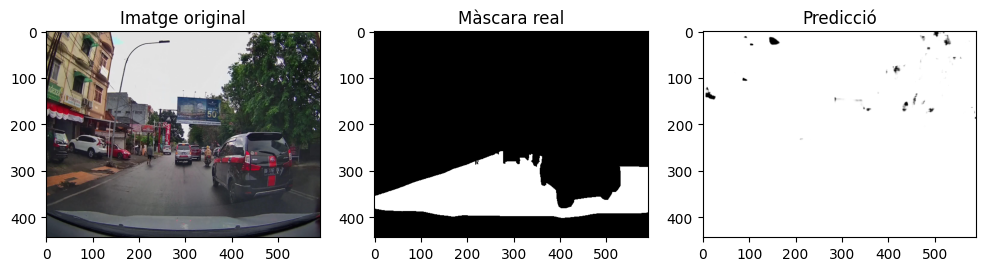

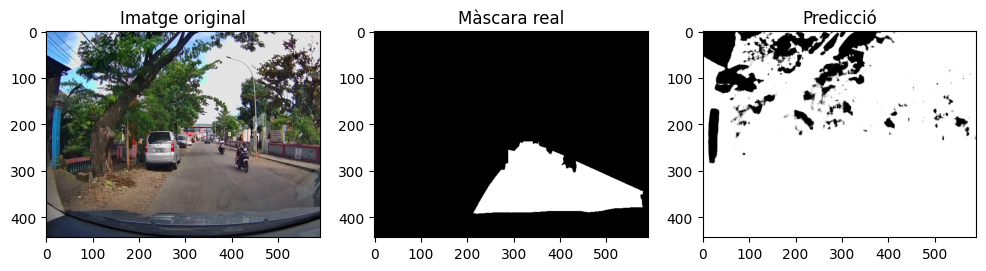

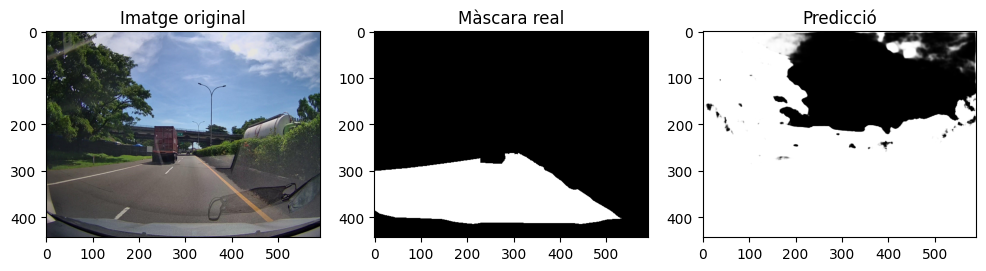

In [298]:
#comprovo com funciona el model
num_samples = 5
sample_indices = random.sample(range(len(images)), num_samples)
print(sample_indices)
sample_images = [images[i] for i in sample_indices]
sample_masks_true = [masks[i] for i in sample_indices]


sample_masks_pred = model.predict(np.array(sample_images))


for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')
    
   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='gray')  
    plt.title('Màscara real')
    
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks_pred[i][:, :, 0], cmap='gray')  
    plt.title('Predicció')
    
    
    plt.show()

sample_masks_pred_model1=sample_masks_pred
#200x200

In [ ]:
# Model 2

In [ ]:

history2=model2.fit(X_train, y_train, epochs=50, batch_size=8,validation_data=(X_test,y_test),callbacks=[early_stopping])


In [ ]:
model2.summary()

In [ ]:
#Faig gràfics per veure com entrena el model2
plt.plot(history2.history['loss'], label='train_loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history2.history['dice_coef'], label='train_dice_coef')
plt.plot(history2.history['val_dice_coef'], label='val_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [ ]:
#comprovo com funciona el model2
#num_samples = 5
#sample_indices = random.sample(range(len(images)), num_samples)
#print(sample_indices)
#sample_images = [images[i] for i in sample_indices]
#sample_masks_true = [masks[i] for i in sample_indices]


sample_masks_pred = model2.predict(np.array(sample_images))


for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')
    
   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='gray')  
    plt.title('Màscara real')
    
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks_pred[i][:, :, 0], cmap='gray')  
    plt.title('Predicció')
    
    
    plt.show()

    
sample_masks_pred_model2=sample_masks_pred

In [ ]:
#num_samples = 5
#sample_indices = random.sample(range(len(images)), num_samples)
#print(sample_indices)
#sample_images = [images[i] for i in sample_indices]
#sample_masks_true = [masks[i] for i in sample_indices]

sample_masks_pred = model2.predict(np.array(sample_images))

for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')

    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='binary')
    plt.title('Màscara real')

   
    imagen_prediccion_pil = sample_masks_pred[i]
    imagen_prediccion_np = np.array(imagen_prediccion_pil)

    # Aplicar umbral a la imagen de predicción
    threshold = 0.07
    imagen_threshold = np.where(imagen_prediccion_np > threshold, 255, 0).astype(np.uint8)

    plt.subplot(1, 3, 3)
    plt.imshow(imagen_threshold, cmap='binary')
    plt.title('Predicció Threshold')

    plt.show()
    plt.show()

In [ ]:
# Model 3

In [ ]:
# Train the model
history3=model3.fit(X_train, y_train, epochs=50, batch_size=8,validation_data=(X_test,y_test),callbacks=[early_stopping])


In [ ]:
model3.summary()

In [ ]:
#Faig gràfics per veure com entrena el model3
plt.plot(history3.history['loss'], label='train_loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history3.history['dice_coef'], label='train_dice_coef')
plt.plot(history3.history['val_dice_coef'], label='val_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [ ]:
#comprovo com funciona el model3
#num_samples = 5
#sample_indices = random.sample(range(len(images)), num_samples)
#print(sample_indices)
#sample_images = [images[i] for i in sample_indices]
#sample_masks_true = [masks[i] for i in sample_indices]


sample_masks_pred = model3.predict(np.array(sample_images))


for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')
    
   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='gray')  
    plt.title('Màscara real')
    
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks_pred[i][:, :, 0], cmap='gray')  
    plt.title('Predicció')
    
    
    plt.show()


sample_masks_pred_model3=sample_masks_pred

In [ ]:
# SAM

In [ ]:
import os 
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2


HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q supervision
import supervision as sv

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

In [ ]:
# Carrego imatges de prova:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

In [ ]:

DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"



sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

IMAGE_NAME = f"resized_image_{sample_indices[0]}.png"
IMAGE_PATH =f"/kaggle/working/resized_image{sample_indices[0]}.png"



image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [ ]:
print(sam_result[0].keys())

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show() 

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/kaggle/working/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda:1"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks_sam = mask_generator.generate(image_rgb)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_anns(masks_sam)
plt.axis('off')
plt.show() 

In [ ]:
# Miro la imatge i la mascara de sam
plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.subplot(1,2,2)
#plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_anns(masks_sam)
plt.axis('off')
plt.show() 

In [ ]:
###### PROVES VARIES###########

In [ ]:
plt.subplot(1,2,1)
image = np.array(Image.open("/kaggle/working/resized_mask1.png"))
image.max()
plt.imshow(image,cmap="gray")
plt.subplot(1,2,2)
image = np.array(Image.open("/kaggle/working/resized_image5.png"))
image.max()
plt.imshow(image,cmap="gray")

## veig que hi ha problema amb les imatges però no aconsegueixo carregar-les bé, crec que ve del procés de redimensió.

In [ ]:

def load_images(image_dir):
    images = {}
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") and "image" in filename:
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path).convert("RGB"))
            normalized_image = image / 255.0
            image_key = filename.replace("_image.png", "")
            images[image_key] = {'image': normalized_image}

    return images

def load_masks(mask_dir):
    masks = {}
    for filename in os.listdir(mask_dir):
        if filename.endswith(".png") and "mask" in filename:
            mask_path = os.path.join(mask_dir, filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            normalized_mask = mask / 255.0
            mask_key = filename.replace("_mask.png", "")
            masks[mask_key] = {'mask': normalized_mask}

    return masks

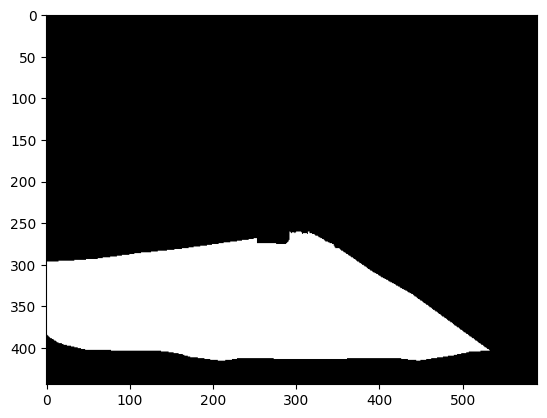

In [211]:
plt.imshow(y_test[30],cmap="gray")

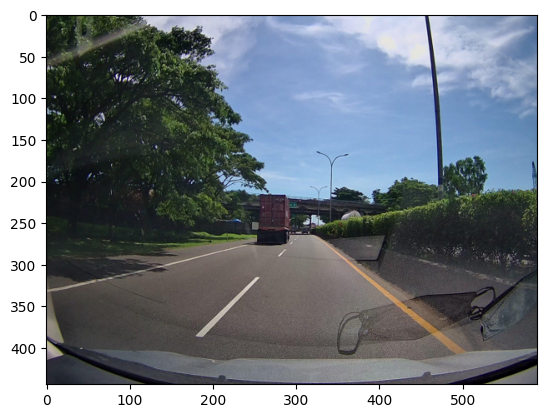

In [213]:
plt.imshow(X_test[30])

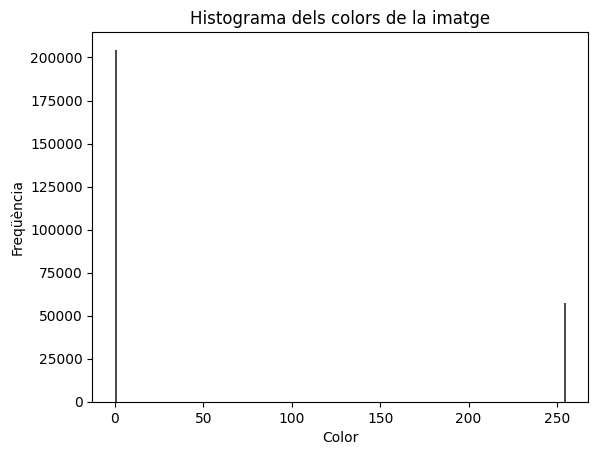

In [247]:
img = y_test[30]
pixels = img.flatten()

plt.hist(pixels, bins=256, color='black', alpha=0.7)

plt.title('Histograma dels colors de la imatge')
plt.xlabel('Color')
plt.ylabel('Freqüència')

plt.show()

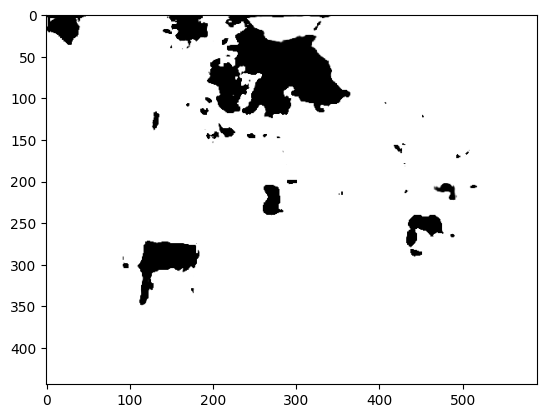

In [258]:
plt.imshow(sample_masks_pred[0],cmap="gray")

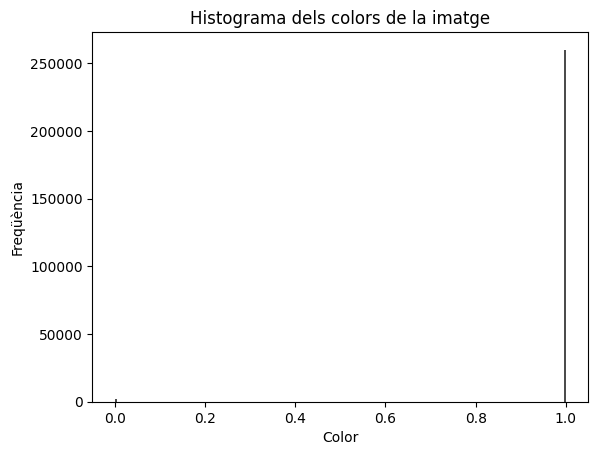

In [259]:
img = sample_masks_pred[3]

pixels = img.flatten()

plt.hist(pixels, bins=256, color='black', alpha=0.7)

plt.title('Histograma dels colors de la imatge')
plt.xlabel('Color')
plt.ylabel('Freqüència')

plt.show()

In [ ]:
#  provar thresholds diferents 